In [118]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import keras
from keras.models import Sequential
from wordcloud import WordCloud,STOPWORDS
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.svm import SVC
import tensorflow as tf
import emoji
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [119]:
#READING#
train=pd.read_csv('D:/Sentiment Analysis/Game/train.csv')
test=pd.read_csv('D:/Sentiment Analysis/Game/test.csv')
game=pd.read_csv('D:/Sentiment Analysis/Game/game_overview.csv')
#

train=train.merge(game,how='left',on='title')
test=test.merge(game,how='left',on='title')

In [120]:
#COMBINING#
master=pd.concat([train,test],ignore_index=True)
master.head()

review_id                        title    year  \
0          1  Spooky's Jump Scare Mansion  2016.0   
1          2  Spooky's Jump Scare Mansion  2016.0   
2          3  Spooky's Jump Scare Mansion  2016.0   
3          4  Spooky's Jump Scare Mansion  2015.0   
4          5  Spooky's Jump Scare Mansion  2015.0   

                                         user_review  user_suggestion  \
0  I'm scared and hearing creepy voices.  So I'll...              1.0   
1  Best game, more better than Sam Pepper's YouTu...              1.0   
2  A littly iffy on the controls, but once you kn...              1.0   
3  Great game, fun and colorful and all that.A si...              1.0   
4  Not many games have the cute tag right next to...              1.0   

      developer     publisher  \
0  Lag Studios   Lag Studios    
1  Lag Studios   Lag Studios    
2  Lag Studios   Lag Studios    
3  Lag Studios   Lag Studios    
4  Lag Studios   Lag Studios    

                                                tags  \
0  ['Horror', 'Free to Play', 'Cute', 'First-Pers...   
1  ['Horror', 'Free to Play', 'Cute', 'First-Pers...   
2  ['Horror', 'Free to Play', 'Cute', 'First-Pers...   
3  ['Horror', 'Free to Play', 'Cute', 'First-Pers...   
4  ['Horror', 'Free to Play', 'Cute', 'First-Pers...   

                                            overview  
0  Can you survive 1000 rooms of cute terror? Or ...  
1  Can you survive 1000 rooms of cute terror? Or ...  
2  Can you survive 1000 rooms of cute terror? Or ...  
3  Can you survive 1000 rooms of cute terror? Or ...  
4  Can you survive 1000 rooms of cute terror? Or ...

In [121]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25539 entries, 0 to 25538
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        25539 non-null  int64  
 1   title            25539 non-null  object 
 2   year             25294 non-null  float64
 3   user_review      25539 non-null  object 
 4   user_suggestion  17494 non-null  float64
 5   developer        25539 non-null  object 
 6   publisher        25539 non-null  object 
 7   tags             25539 non-null  object 
 8   overview         25539 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.8+ MB


In [122]:
# CHECK UNIQUE VALUES

master.apply(lambda x : len(x.unique()))

review_id          25539
title                 64
year                   9
user_review        25535
user_suggestion        3
developer             59
publisher             54
tags                  64
overview              62
dtype: int64

In [123]:
master.isnull().sum()/len(master)*100

review_id           0.000000
title               0.000000
year                0.959317
user_review         0.000000
user_suggestion    31.500842
developer           0.000000
publisher           0.000000
tags                0.000000
overview            0.000000
dtype: float64

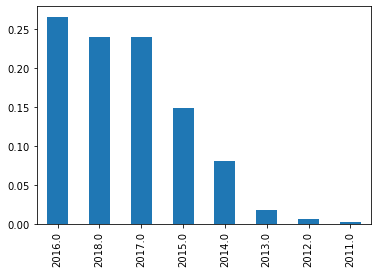

In [124]:
master['year'].value_counts(normalize=True).plot(kind='bar')

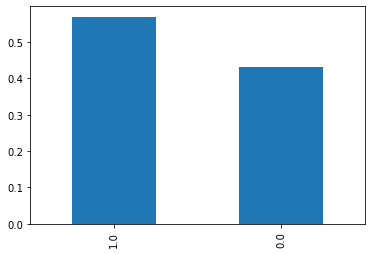

In [125]:
#TARGET VARIABLE#
master['user_suggestion'].value_counts(normalize=True).plot(kind='bar')

In [126]:
#Final output#
master['text']=master['title'] + " " + master['user_review'] + " " + master['developer'] + " " + master['tags'] + " " + master['overview']
 
del master['title']
del master['user_review']
del master['developer']
del master['tags']
del master['overview']
del master['publisher']
del master['year']

# DATA CLEANING#

In [127]:
  #lower text,REMOVING Hyperlinks,punctuation,brackets,remove words containg numbers,remove ascii

def clean_text(text):
    text=text.lower()
    text=re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    
master['text']=master['text'].apply(lambda x:clean_text(x))    
master.head()    

review_id  user_suggestion  \
0          1              1.0   
1          2              1.0   
2          3              1.0   
3          4              1.0   
4          5              1.0   

                                                text  
0  spookys jump scare mansion im scared and heari...  
1  spookys jump scare mansion best game more bett...  
2  spookys jump scare mansion a littly iffy on th...  
3  spookys jump scare mansion great game fun and ...  
4  spookys jump scare mansion not many games have...

# CONTRACTIONS#

In [128]:

CONTRACTION_MAP = {"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",
"could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not",
"don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would",
"he'd've": "he would have","he'll": "he will","he'll've": "he he will have","he's": "he is","how'd": "how did","how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"im" : "i am",
"youve": " you have ",
" ive " : " i have ",
"doesnt" : " does not ",
" youre ":" you are ",
" cant " : " can not " ,
" thats " : " that is ",
" wou're " : " you are "                   
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

master['text']=master['text'].apply(lambda x:expand_contractions(x))    
master.head()    

review_id  user_suggestion  \
0          1              1.0   
1          2              1.0   
2          3              1.0   
3          4              1.0   
4          5              1.0   

                                                text  
0  spookys jump scare mansion i am scared and hea...  
1  spookys jump scare mansion best game more bett...  
2  spookys jump scare mansion a littly iffy on th...  
3  spookys jump scare mansion great game fun and ...  
4  spookys jump scare mansion not many games have...

# TOKENIZATION#

In [129]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
master['text'] = master['text'].apply(lambda x: tokenizer.tokenize(x))
master.head(3)

Wall time: 6.57 s


review_id  user_suggestion  \
0          1              1.0   
1          2              1.0   
2          3              1.0   

                                                text  
0  [spookys, jump, scare, mansion, i, am, scared,...  
1  [spookys, jump, scare, mansion, best, game, mo...  
2  [spookys, jump, scare, mansion, a, littly, iff...

# STOPWORDS & LEMMATISER#

In [130]:
%%time
stop_words=stopwords.words('english')
wc=WordNetLemmatizer()

def rm_stopwords(text):
    words=[wc.lemmatize(w) for w in text if w not in stop_words]
    return words
master['text'] = master['text'].apply(lambda x : rm_stopwords(x))
master['text'].head(3)

Wall time: 1min 11s


0    [spookys, jump, scare, mansion, scared, hearin...
1    [spookys, jump, scare, mansion, best, game, be...
2    [spookys, jump, scare, mansion, littly, iffy, ...
Name: text, dtype: object

# VOC SIZE FINDER#

In [120]:
#Creating Word Vectors by Word2Vec Method (takes time...)
#Dimension of vectors we are generating
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=master['text'], size=EMBEDDING_DIM, window=5, min_count=1)
#vocab size
len(w2v_model.wv.vocab)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


# JOINING#

In [131]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

master['text'] = master['text'].apply(lambda x : combine_text(x))
master['text'].head(3)

Wall time: 511 ms


0    spookys jump scare mansion scared hearing cree...
1    spookys jump scare mansion best game better sa...
2    spookys jump scare mansion littly iffy control...
Name: text, dtype: object

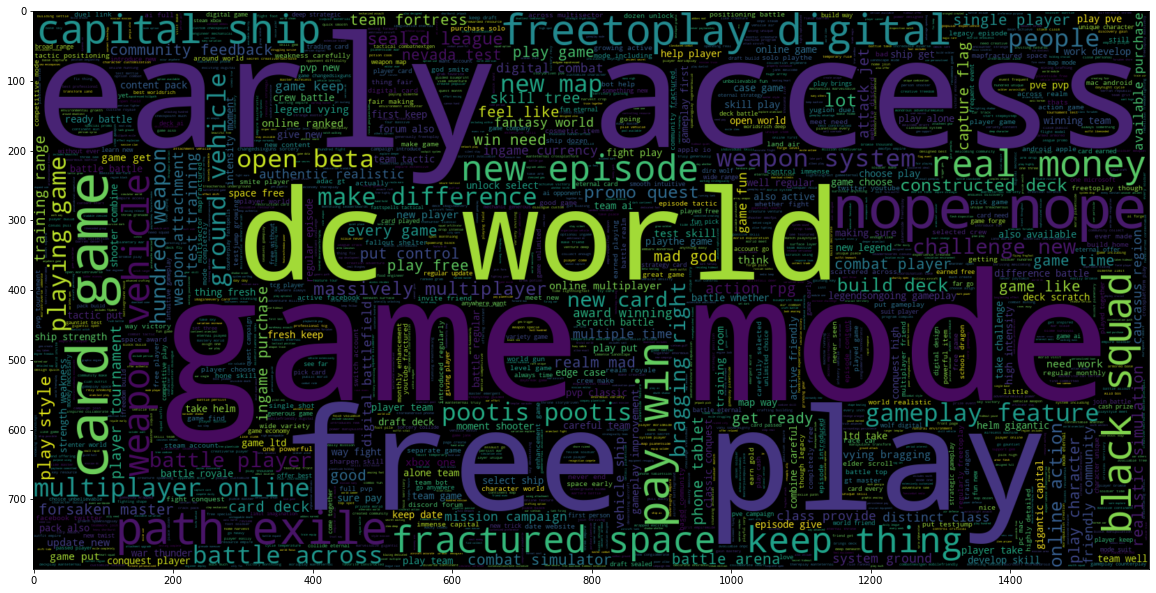

In [12]:
#True

plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(master[master.user_suggestion == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

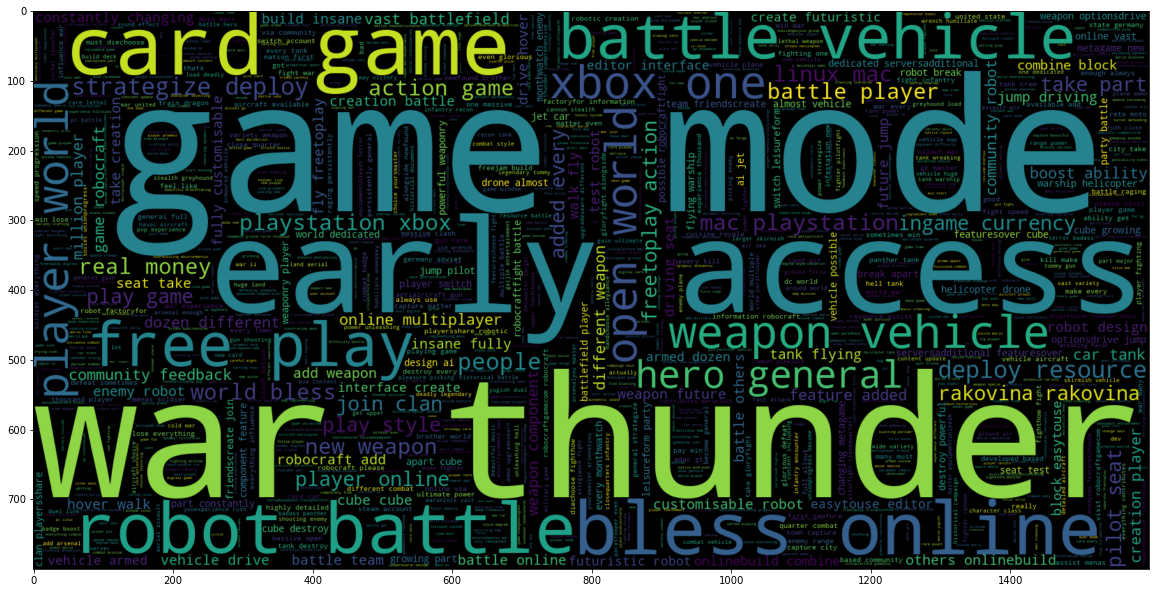

In [13]:
plt.figure(figsize = (20,20)) # Text that is  Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(master[master.user_suggestion == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# MODEL BUIDINIG#


In [132]:
X = master[master['user_suggestion'].isnull()!=True].drop(['review_id','user_suggestion'], axis=1)
X = X['text'].tolist()
y = master[master['user_suggestion'].isnull()!=True]['user_suggestion']
X_test = master[master['user_suggestion'].isnull()==True].drop(['review_id','user_suggestion'], axis=1)

# ONE HOT ENCODING #

In [133]:
voc_size=72954
onehot_repr=[one_hot(words,voc_size)for words in X] 
onehot_repr

[[52533,
  17366,
  52977,
  69701,
  10175,
  43078,
  37390,
  22298,
  1250,
  51911,
  32493,
  36322,
  32038,
  12563,
  41402,
  11161,
  20241,
  30306,
  19339,
  60750,
  56777,
  70522,
  54668,
  61575,
  37390,
  53140,
  39606,
  58397,
  63121,
  15904,
  13499,
  30285,
  50133,
  64457,
  45501,
  56963,
  7794,
  53385,
  26540,
  72827,
  15968,
  64511,
  8029,
  22472,
  16506,
  34302,
  4875,
  47363,
  42792,
  2972,
  34715,
  10775,
  18951,
  44313,
  42729,
  8106,
  65835,
  49684,
  11324,
  64980,
  37390,
  41840,
  1250,
  17947,
  15092,
  64544,
  64544,
  60130,
  40181,
  23434,
  54668,
  55269,
  62171,
  58800,
  64915,
  47321,
  7284,
  16860,
  42792,
  22087,
  40191,
  3601,
  23654,
  64439,
  22905,
  30968,
  59858,
  68754,
  51612,
  68929,
  70226,
  22020,
  31111,
  41989,
  12563,
  12563,
  58243,
  49454,
  67580,
  42289,
  31035,
  69322,
  45066,
  44877,
  61746,
  49867,
  57868,
  51529,
  41772,
  11161,
  11472,
  3693,
  

# EMBEDDING REPRESENTATION#

In [134]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[41989 12563 12563 ... 11472  3693 55899]
 [41989 12563 12563 ... 11472  3693 55899]
 [41989 12563 12563 ... 11472  3693 55899]
 ...
 [22040 30561  6084 ... 60576  2882 55151]
 [22040 30561  6084 ... 60576  2882 55151]
 [22040 30561  6084 ... 60576  2882 55151]]


In [147]:
X_final=np.array(embedded_docs)
y_final=np.array(y)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# BIDIRECTIONAL LSTM#

In [148]:
## Creating model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 40)            2918160   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               112800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 3,031,161
Trainable params: 3,031,161
Non-trainable params: 0
_________________________________________________________________
None


# LSTM#

In [149]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 40)            2918160   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,974,661
Trainable params: 2,974,661
Non-trainable params: 0
_________________________________________________________________
None


In [151]:
###  BIDIRECTIONAL FIT Finally Training
model1.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10,batch_size=64)

Epoch 1/10
184/184 [==============================] - 15s 83ms/step - loss: 0.5585 - accuracy: 0.6995 - val_loss: 0.5266 - val_accuracy: 0.7298
Epoch 2/10
184/184 [==============================] - 14s 78ms/step - loss: 0.5306 - accuracy: 0.7226 - val_loss: 0.5273 - val_accuracy: 0.7224
Epoch 3/10
184/184 [==============================] - 14s 78ms/step - loss: 0.5254 - accuracy: 0.7251 - val_loss: 0.5215 - val_accuracy: 0.7354
Epoch 4/10
184/184 [==============================] - 15s 82ms/step - loss: 0.5214 - accuracy: 0.7337 - val_loss: 0.5209 - val_accuracy: 0.7279
Epoch 5/10
184/184 [==============================] - 10s 57ms/step - loss: 0.5182 - accuracy: 0.7323 - val_loss: 0.5213 - val_accuracy: 0.7283
Epoch 6/10
184/184 [==============================] - 8s 41ms/step - loss: 0.5098 - accuracy: 0.7320 - val_loss: 0.5262 - val_accuracy: 0.7248
Epoch 7/10
184/184 [==============================] - 7s 40ms/step - loss: 0.5078 - accuracy: 0.7292 - val_loss: 0.5250 - val_accuracy: 0

In [153]:
y_pred1=model1.predict_classes(x_val)
accuracy_score(y_val,y_pred1)
print(classification_report(y_val,y_pred1))

              precision    recall  f1-score   support

         0.0       0.71      0.59      0.64      2451
         1.0       0.73      0.83      0.77      3323

    accuracy                           0.72      5774
   macro avg       0.72      0.71      0.71      5774
weighted avg       0.72      0.72      0.72      5774



In [154]:
### Finally Training ON LSTM
model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10,batch_size=64)

Epoch 1/10
184/184 [==============================] - 7s 36ms/step - loss: 0.5286 - accuracy: 0.7212 - val_loss: 0.5201 - val_accuracy: 0.7328
Epoch 2/10
184/184 [==============================] - 6s 35ms/step - loss: 0.5223 - accuracy: 0.7307 - val_loss: 0.5180 - val_accuracy: 0.7326
Epoch 3/10
184/184 [==============================] - 6s 34ms/step - loss: 0.5148 - accuracy: 0.7360 - val_loss: 0.5233 - val_accuracy: 0.7321
Epoch 4/10
184/184 [==============================] - 6s 35ms/step - loss: 0.5099 - accuracy: 0.7340 - val_loss: 0.5205 - val_accuracy: 0.7293
Epoch 5/10
184/184 [==============================] - 6s 35ms/step - loss: 0.5060 - accuracy: 0.7382 - val_loss: 0.5262 - val_accuracy: 0.7321
Epoch 6/10
184/184 [==============================] - 6s 35ms/step - loss: 0.5041 - accuracy: 0.7352 - val_loss: 0.5255 - val_accuracy: 0.7324
Epoch 7/10
184/184 [==============================] - 7s 35ms/step - loss: 0.5027 - accuracy: 0.7378 - val_loss: 0.5297 - val_accuracy: 0.7310

In [155]:
y_pred=model.predict_classes(x_val)
from sklearn.metrics import accuracy_score
accuracy_score(y_val,y_pred)

0.7289573952199515